In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
BATCH_SIZE = 5

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True, #랜덤하게 50%를 생성
                                  width_shift_range=0.1, #좌/우 10%범위내에서 이동
                                  height_shift_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory('train',
                                                   target_size=(150,150),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory('test',
                                                   target_size=(150,150),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [3]:
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
transfer_model.trainable = False
transfer_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)
finetune_model.add(layers.Flatten())
finetune_model.add(layers.Dense(64, activation='relu'))
finetune_model.add(layers.Dense(2, activation='softmax'))
finetune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                524352    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


In [5]:
finetune_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.0002),
             metrics=['accuracy'])

steps_train = len(train_generator)
steps_test = len(test_generator)

history = finetune_model.fit(train_generator,
                   steps_per_epoch=steps_train,
                   epochs=20,
                   validation_data=test_generator,
                   validation_steps=steps_test)

Epoch 1/20
32/32 [==============================] - 15s 463ms/step - loss: 0.5458 - accuracy: 0.7000 - val_loss: 0.4237 - val_accuracy: 0.7833
Epoch 2/20
32/32 [==============================] - 14s 448ms/step - loss: 0.3177 - accuracy: 0.8813 - val_loss: 0.2806 - val_accuracy: 0.9167
Epoch 3/20
32/32 [==============================] - 14s 450ms/step - loss: 0.2495 - accuracy: 0.9563 - val_loss: 0.2292 - val_accuracy: 0.9417
Epoch 4/20
32/32 [==============================] - 15s 455ms/step - loss: 0.2522 - accuracy: 0.8750 - val_loss: 0.1889 - val_accuracy: 0.9417
Epoch 5/20
32/32 [==============================] - 15s 455ms/step - loss: 0.1505 - accuracy: 0.9750 - val_loss: 0.1875 - val_accuracy: 0.9417
Epoch 6/20
32/32 [==============================] - 15s 458ms/step - loss: 0.1501 - accuracy: 0.9563 - val_loss: 0.1549 - val_accuracy: 0.9417
Epoch 7/20
32/32 [==============================] - 15s 459ms/step - loss: 0.1776 - accuracy: 0.9312 - val_loss: 0.1922 - val_accuracy: 0.9167

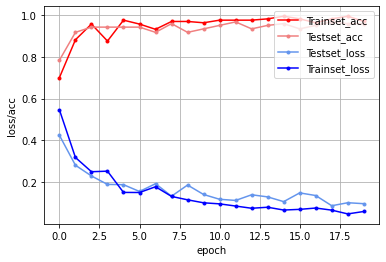

In [6]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))  
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

plt.legend(loc='upper right') 
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()